In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
import math
import heapq
import warnings
from copy import deepcopy
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("train_set.csv")
user, movie, score = df['userId'].values, df['movieId'].values, df['rating'].values
users = {}
moviesSet = set()
for i in range(len(user)):
    moviesSet.add(movie[i])
    if user[i] not in users:
        users.update({user[i] : {movie[i] : score[i]}})
    else:
        users[user[i]].update({movie[i] : score[i]})
    

In [3]:
class recommendByUsers(object):
    def __init__(self, data, pattern, avg):
        self.data = data
        self.pattern = pattern
        self.avg = avg
    
    def getItems(self, userId1, userId2):
        return self.data[userId1], self.data[userId2]
    
    def calPearson(self, userId1 : dict, userId2 : dict):
        n, sumXY, sumX1, sumY1, sumX2, sumY2 = 0, 0.0, 0.0, 0.0, 0.0, 0.0
        for movie1, score1 in userId1.items():
            if movie1 in userId2:
                n += 1
                sumXY += score1 * userId2[movie1]
                sumX1 += score1
                sumY1 += userId2[movie1]
                sumX2 += math.pow(score1, 2)
                sumY2 += math.pow(userId2[movie1], 2)
        if n == 0:
            return 0
        denominator = math.sqrt((sumX2 - (math.pow(sumX1, 2) / n)) * (sumY2 - (math.pow(sumY1, 2) / n)))
        molecure = sumXY - (sumX1 * sumY1) / n
        if molecure == 0 or denominator == 0:
            return 0
        return molecure / denominator

    def createPearsonMatrix(self):
        peopleSum = len(self.data.keys())
        self.mat = np.zeros(shape=(peopleSum + 1,peopleSum + 1))
        for i in range(1, peopleSum + 1):
            if i + 1 <= peopleSum:
                for j in range(i + 1, peopleSum + 1):
                    self.mat[i][j] = self.mat[j][i] = self.calPearson(self.data[i], self.data[j])
    
    def recommendSingle(self, userId, k, n):
        if self.pattern == 'zero':
            return self.recommend1(userId, k, n)
        elif self.pattern == 'avg':
            return self.recommend2(userId, k, n)
    
    def recommend1(self, userId, k, n):
        # 为单个人userId推荐n个
        index = np.argsort(self.mat[userId][1 : ])[-k : ]  # k个最相似的用户号
        allMovieScore, contributionSum = {}, {}
        # 计算
        for id in index:
            # 问题1
            if id == 0 or self.mat[userId][id] < 0:
                continue
            else:
                for movie, score in self.data[id].items():
                    if movie in allMovieScore:
                        allMovieScore[movie] += score * self.mat[userId][id]
                        contributionSum[movie] += self.mat[userId][id]
                    else:
                        allMovieScore.update({movie : score * self.mat[userId][id]})
                        contributionSum.update({movie : self.mat[userId][id]})
        # 已评分的电影id在推荐中删除
        for movie in self.data[userId].keys():
            if movie in allMovieScore:
                del allMovieScore[movie]
        # 经过k个最相似用户的评分处理后的userId用户的新评分
        for movie in allMovieScore.keys():
            if contributionSum[movie] != 0:
                allMovieScore[movie] /= contributionSum[movie]
        recommendList = sorted(allMovieScore.items(), key=lambda x:x[1], reverse=True)
        return allMovieScore, recommendList[:min(n, len(recommendList))] # 评分,推荐列表
    
    def recommend2(self, userId, k, n):
        # 为单个人userId推荐n个
        index = np.argsort(self.mat[userId][1 : ])[-k : ]  # k个最相似的用户号
        allMovieScore, contributionSum = {movie : 0 for movie in self.avg.keys()}, 0.0
        # 计算
        for id in index:
            # 问题1
            sim = self.mat[userId][id]
            if id == 0 or sim < 0:
                continue
            else:
                for movie, score in self.avg.items():
                    allMovieScore[movie] += score * sim
                for movie, score in self.data[id].items():
                    allMovieScore[movie] += score * sim - avg[movie] * sim
                contributionSum += sim
        # 已评分的电影id在推荐中删除
        for movie in self.data[userId].keys():
            if movie in allMovieScore:
                del allMovieScore[movie]
        # 经过k个最相似用户的评分处理后的userId用户的新评分
        for movie in allMovieScore.keys():
            allMovieScore[movie] /= contributionSum
        recommendList = sorted(allMovieScore.items(), key=lambda x:x[1], reverse=True)
        return allMovieScore, recommendList[:min(n, len(recommendList))] # 评分,推荐列表

In [4]:
testData = pd.read_csv("test_set.csv")
testUsers, testMovies, rating = testData['userId'].values, testData['movieId'].values, testData['rating'].values

In [5]:
def testResult(testUsers, testMovies, users, recommender, k, n):
    res = []
    cache = {} # 缓存结果
    for user, movie in zip(testUsers, testMovies):
        if movie in users[user]:
                res.append(users[user][movie])
        elif user in cache:
            if movie in cache[user]:
                res.append(cache[user][movie])
            else:
                res.append(0)
        else:
            addedMovieScore, recommend = recommender.recommendSingle(user, k, n)
            cache.update({user : addedMovieScore})
            if movie in addedMovieScore:
                res.append(addedMovieScore[movie])
            else:
                res.append(0)
    return res

In [6]:
avg = {} # 平均分
scoreSum, contributorSum = {}, {}
for user, statement in users.items():
    for movie, score in statement.items():
        if movie in scoreSum:
            scoreSum[movie] += score
            contributorSum[movie] += 1
        else:
            scoreSum.update({movie : score})
            contributorSum.update({movie : 1})
for movie, score in scoreSum.items():
    avg.update({movie : score / contributorSum[movie]})

In [38]:
recommender = recommendByUsers(users, 'zero', avg)
recommender.createPearsonMatrix()

In [40]:
result = testResult(testUsers, testMovies, users, recommender, 30, 3)
SSE = np.sum(np.square(np.array(result) - rating))

In [41]:
SSE # 0

115.70765326470769

In [7]:
recommender1 = recommendByUsers(users, 'avg', avg)
recommender1.createPearsonMatrix()
result1 = testResult(testUsers, testMovies, users, recommender1, 30, 3)
SSE1 = np.sum(np.square(np.array(result1) - rating))

In [8]:
SSE1 # avg

82.75699952715188

In [8]:
res = []
for num in range(100, 301, 10):
    result = testResult(testUsers, testMovies, users, recommender, num, 3)
    SSE = np.sum(np.square(np.array(result) - rating))
    res.append(SSE)

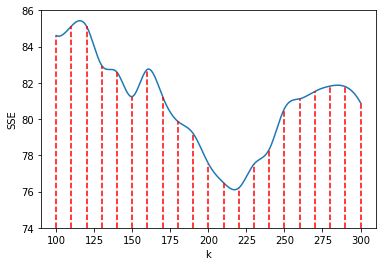

In [18]:
# 0填补
from scipy.interpolate import interp1d
x = np.arange(100, 301, 10)
res = np.array(res)
xnew = np.linspace(x.min(), x.max(), 3000)
func = interp1d(x, res, kind='cubic')
ynew = func(xnew)
plt.plot(xnew, ynew)
for i in range(len(x)):
    plt.plot([x[i], x[i]], [74, res[i]], c='r', linestyle='--')
plt.xlabel('k')
plt.ylabel('SSE')
plt.ylim(74)
plt.show()

In [9]:
res = []
for num in range(10, 101, 10):
    result = testResult(testUsers, testMovies, users, recommender1, num, 3)
    SSE = np.sum(np.square(np.array(result) - rating))
    res.append(SSE)

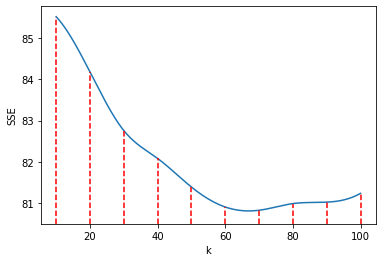

In [11]:
# avg填补
from scipy.interpolate import interp1d
x = np.arange(10, 101, 10)
res = np.array(res)
xnew = np.linspace(x.min(), x.max(), 1000)
func = interp1d(x, res, kind='cubic')
ynew = func(xnew)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(xnew, ynew)
for i in range(len(x)):
    plt.plot([x[i], x[i]], [80.5, res[i]], c='r', linestyle='--')
plt.ylim(80.5)
plt.show()

In [9]:
scores, recommends = recommender1.recommendSingle(29, 30, 5)
print(recommends)

[(2086, 5.0), (6598, 5.0), (3879, 5.0), (1859, 5.0), (4302, 5.0)]
